# Libraries

In [2]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
warnings.filterwarnings('ignore')

In [3]:
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
import itertools
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix, recall_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
#!pip install shap
import shap
import xgboost

# load JS visualization code to notebook
shap.initjs()

# Data review

### first look

In [5]:
train = pd.read_csv("../Dasha_ML_Coding/santander-customer-transaction-prediction/train.csv")
train.head(3)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965


In [6]:
train.tail(3)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
199997,train_199997,0,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,train_199998,0,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001
199999,train_199999,0,10.8762,-5.7105,12.1183,8.0328,11.5577,0.3488,5.2839,15.2058,...,8.9842,1.6893,0.1276,0.3766,15.2101,-2.4907,-2.2342,8.1857,12.1284,0.1385


In [7]:
test = pd.read_csv("../Dasha_ML_Coding/santander-customer-transaction-prediction/test.csv")
test.head(3)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794


In [8]:
test.tail(3)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
199997,test_199997,11.6360,2.2769,11.2074,7.7649,12.6796,11.3224,5.3883,18.3794,1.6603,...,5.1536,2.6498,2.4937,-0.0637,20.0609,-1.1742,-4.1524,9.1933,11.7905,-22.2762
199998,test_199998,13.5745,-0.5134,13.6584,7.4855,11.2241,-11.3037,4.1959,16.8280,5.3208,...,3.4259,8.5012,2.2713,5.7621,17.0056,1.1763,-2.3761,8.1079,8.7735,-0.2122
199999,test_199999,10.4664,1.8070,10.2277,6.0654,10.0258,1.0789,4.8879,14.4892,-0.5902,...,0.1398,9.2828,1.3601,4.8985,20.0926,-1.3048,-2.5981,10.3378,14.3340,-7.7094


In [9]:
train.shape, test.shape

((200000, 202), (200000, 201))

In [10]:
train.columns, test.columns

(Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
        'var_5', 'var_6', 'var_7',
        ...
        'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
        'var_196', 'var_197', 'var_198', 'var_199'],
       dtype='object', length=202),
 Index(['ID_code', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5',
        'var_6', 'var_7', 'var_8',
        ...
        'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
        'var_196', 'var_197', 'var_198', 'var_199'],
       dtype='object', length=201))

### Let's check if there are any missing data. We will also chech the type of data.

In [11]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [12]:
%%time
missing_data(train).T

CPU times: user 323 ms, sys: 235 ms, total: 558 ms
Wall time: 712 ms


,Total,Percent,Types
ID_code,0,0.0,object
target,0,0.0,int64
var_0,0,0.0,float64
var_1,0,0.0,float64
var_2,0,0.0,float64
...,...,...,...
var_195,0,0.0,float64
var_196,0,0.0,float64
var_197,0,0.0,float64
var_198,0,0.0,float64


In [13]:
train.isnull().sum()

ID_code    0
target     0
var_0      0
var_1      0
var_2      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 202, dtype: int64

In [14]:
train.duplicated().sum()

0

In [15]:
train = train.drop_duplicates()

### Let's check the numerical values in train and test dataset.

In [16]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 309.8+ MB


In [18]:
train.nunique()

ID_code    200000
target          2
var_0       94672
var_1      108932
var_2       86555
            ...  
var_195     57870
var_196    125560
var_197     40537
var_198     94153
var_199    149430
Length: 202, dtype: int64

In [19]:
col_names = train.columns
for c in col_names:
    train = train.replace("?", np.NaN)
train = train.apply(lambda x: x.fillna(x.value_counts().index[0]))

# Data visualization

## Let's plot the scatter plot for dataset for few of the features.

In [20]:
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,4,figsize=(14,14))

    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show();

<Figure size 432x288 with 0 Axes>

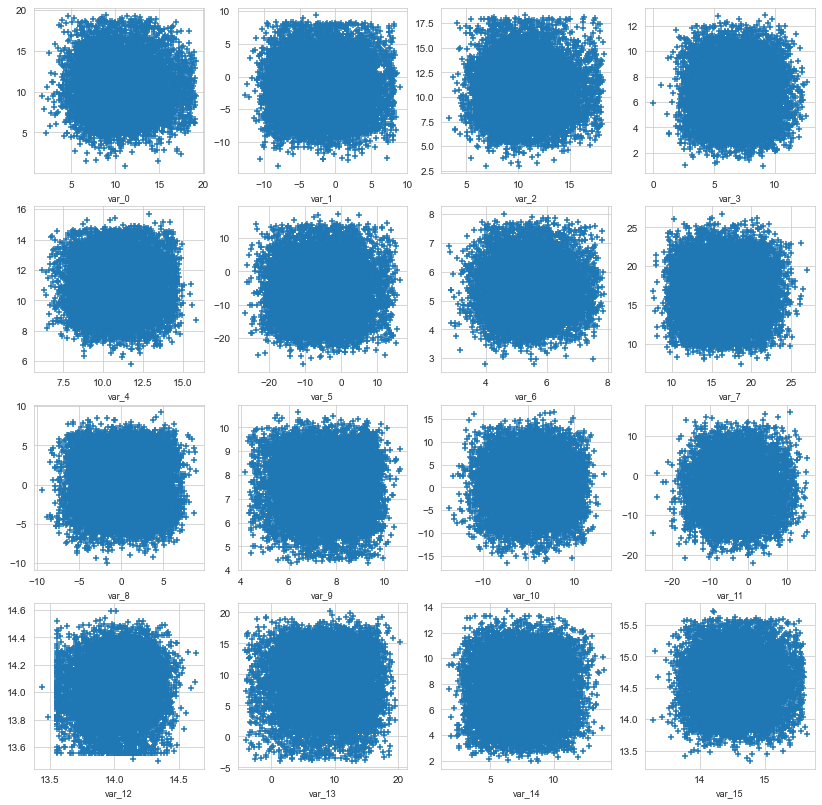

In [21]:
features = ['var_0', 'var_1','var_2','var_3', 'var_4', 'var_5', 'var_6', 'var_7', 
           'var_8', 'var_9', 'var_10','var_11','var_12', 'var_13', 'var_14', 'var_15', 
           ]
plot_feature_scatter(train[::20],test[::20], features)

## Let's check the distribution of target value in train dataset.

<AxesSubplot:xlabel='target', ylabel='count'>

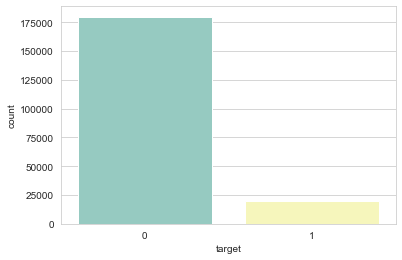

In [22]:
sns.countplot(train['target'], palette='Set3')

In [23]:
print("There are {}% target values with 1".format(100 * train["target"].value_counts()[1]/train.shape[0]))

There are 10.049% target values with 1


## Density plots of features
Let's show now the density plot of variables in train dataset.
We represent with different colors the distribution for values with target value 0 and 1.

In [24]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(3,3,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(3,3,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

<Figure size 432x288 with 0 Axes>

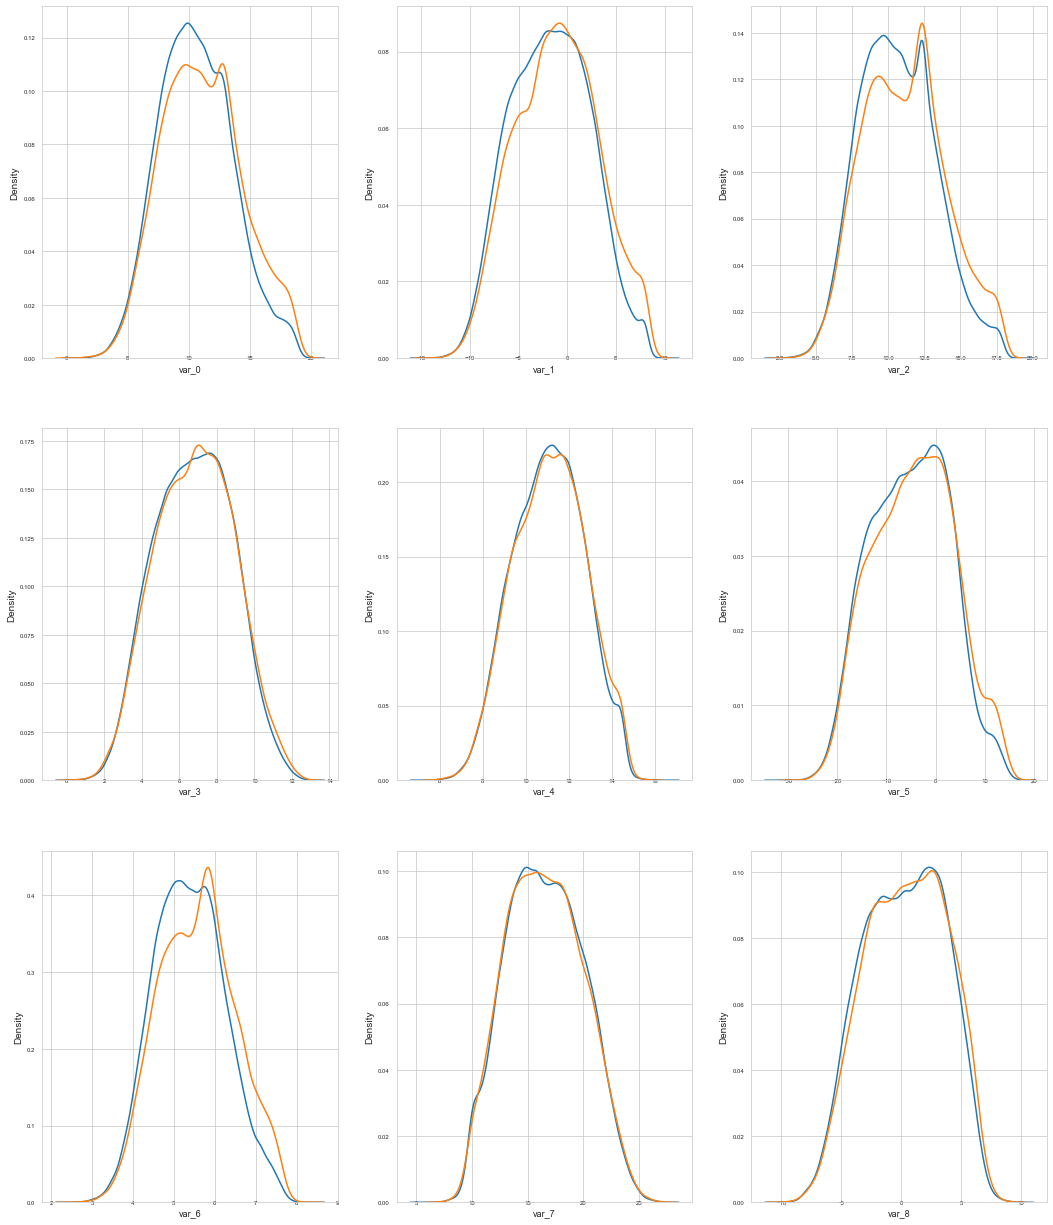

In [25]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
features = train.columns.values[2:11]
plot_feature_distribution(t0, t1, '0', '1', features)

## Distribution of mean and std


**Let's show the distribution of standard deviation of values per row for train dataset.**

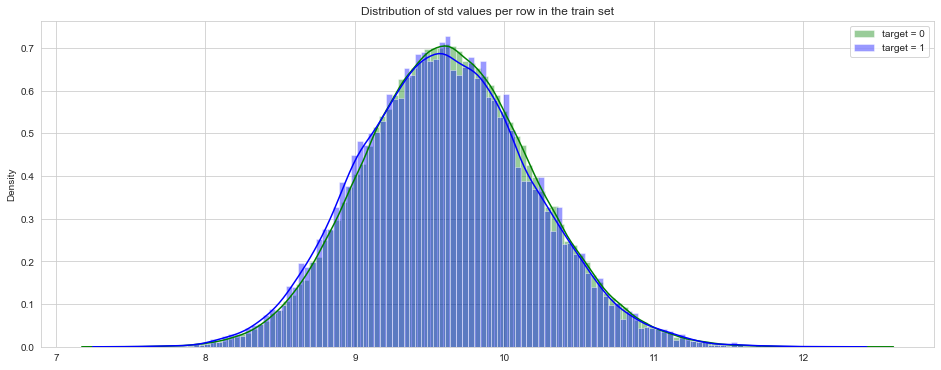

In [26]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
plt.figure(figsize=(16,6))
features = train.columns.values[2:200]
plt.title("Distribution of std values per row in the train set")
sns.distplot(t0[features].std(axis=1),color="green", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].std(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

**Let's check now the distribution of the mean value per row in the train dataset, grouped by value of target.**

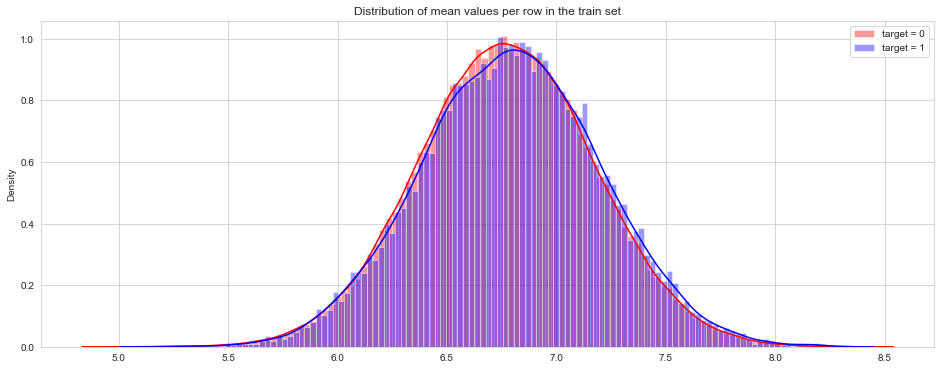

In [27]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[features].mean(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

# Features correlation
We calculate now the correlations between the features in train set.
The following table shows the first 10 the least correlated features.

In [28]:
%%time
correlations = train[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.tail(10)

CPU times: user 17.3 s, sys: 572 ms, total: 17.9 s
Wall time: 21.6 s


,level_0,level_1,0
38996,var_183,var_189,0.009359
38997,var_189,var_183,0.009359
38998,var_174,var_81,0.009490
38999,var_81,var_174,0.009490
39000,var_81,var_165,0.009714
39001,var_165,var_81,0.009714
39002,var_53,var_148,0.009788
39003,var_148,var_53,0.009788
39004,var_26,var_139,0.009844
39005,var_139,var_26,0.009844


# Duplicate values
Let's now check how many duplicate values exists per columns.

In [29]:
train.duplicated().sum()

0

In [30]:
train = train.drop_duplicates()

In [31]:
%%time
features = train.columns.values[2:202]
unique_max_train = []
for feature in features:
    values = train[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])

CPU times: user 3.11 s, sys: 322 ms, total: 3.43 s
Wall time: 3.78 s


In [32]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,68,108,126,12,91,103,148,71,161,25,125,169,166,133,43
Feature,var_68,var_108,var_126,var_12,var_91,var_103,var_148,var_71,var_161,var_25,var_125,var_169,var_166,var_133,var_43
Max duplicates,1084,313,305,203,66,61,59,54,52,41,40,39,39,39,39
Value,5.0214,14.1999,11.5356,13.5545,6.9785,1.6662,4.0456,0.7031,5.7688,13.6723,12.5159,5.6941,2.7306,6.8632,11.5531


# Feature engineering
Let's calculate for starting few aggregated values for the existing features.

In [33]:
%%time
idx = features = train.columns.values[2:202]
for df in [test, train]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

CPU times: user 9.69 s, sys: 6.93 s, total: 16.6 s
Wall time: 21.2 s


In [34]:
train[train.columns[202:]].head(3)

,sum,min,max,mean,std,skew,kurt,med
0,1456.3182,-21.4494,43.1127,7.281591,9.331540,0.101580,1.331023,6.77040
1,1415.3636,-47.3797,40.5632,7.076818,10.336130,-0.351734,4.110215,7.22315
2,1240.8966,-22.4038,33.8820,6.204483,8.753387,-0.056957,0.546438,5.89940


### We add rounded features.

In [35]:
%%time
#features = [c for c in train.columns if c not in ['ID_code', 'target']]
#for feature in features:
#    train['r2_'+feature] = np.round(train[feature], 2)
#    test['r2_'+feature] = np.round(test[feature], 2)
#    train['r1_'+feature] = np.round(train[feature], 1)
#    test['r1_'+feature] = np.round(test[feature], 1)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


In [36]:
print('Train and test columns: {} {}'.format(len(train.columns), len(test.columns)))

Train and test columns: 210 209


# Modeling

### Choose categorical and continuous features from data

In [37]:
categorical_columns = [c for c in test.columns 
                       if test[c].dtype.name == 'object' and test[c].name != 'ID_code']
numerical_columns = [c for c in test.columns 
                     if test[c].dtype.name != 'object' and test[c].name != 'target']

print('categorical_columns:', categorical_columns)
print('numerical_columns:', numerical_columns)

categorical_columns: []
numerical_columns: ['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'var_8', 'var_9', 'var_10', 'var_11', 'var_12', 'var_13', 'var_14', 'var_15', 'var_16', 'var_17', 'var_18', 'var_19', 'var_20', 'var_21', 'var_22', 'var_23', 'var_24', 'var_25', 'var_26', 'var_27', 'var_28', 'var_29', 'var_30', 'var_31', 'var_32', 'var_33', 'var_34', 'var_35', 'var_36', 'var_37', 'var_38', 'var_39', 'var_40', 'var_41', 'var_42', 'var_43', 'var_44', 'var_45', 'var_46', 'var_47', 'var_48', 'var_49', 'var_50', 'var_51', 'var_52', 'var_53', 'var_54', 'var_55', 'var_56', 'var_57', 'var_58', 'var_59', 'var_60', 'var_61', 'var_62', 'var_63', 'var_64', 'var_65', 'var_66', 'var_67', 'var_68', 'var_69', 'var_70', 'var_71', 'var_72', 'var_73', 'var_74', 'var_75', 'var_76', 'var_77', 'var_78', 'var_79', 'var_80', 'var_81', 'var_82', 'var_83', 'var_84', 'var_85', 'var_86', 'var_87', 'var_88', 'var_89', 'var_90', 'var_91', 'var_92', 'var_93', 'var_94', 'var_95', 'var_9

In [38]:
train_1 = pd.concat([train[numerical_columns]])#,
#    pd.get_dummies(train[categorical_columns])], axis=1)

test_1 = pd.concat([test[numerical_columns]])#,
#    pd.get_dummies(test[categorical_columns])], axis=1)

### Train test split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['target', 'ID_code'], 1), train['target'],
                                                    test_size=.95, shuffle=True)

### Models quality collector

In [40]:
results = []

def evaluate_results(name, y_fact, y_predict, y_fact_train, y_predict_train):
    print('Classification results:')
    f1 = f1_score(y_fact, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_fact, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    gini_train = 2*roc_auc_score(y_fact_train, y_predict_train)-1
    print("gini_train: %.2f%%" % (gini_train * 100.0)) 
    gini_test = 2*roc_auc_score(y_fact, y_predict)-1
    print("gini_test: %.2f%%" % (gini_test * 100.0)) 
    rec = recall_score(y_fact, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_fact, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 
    acc = accuracy_score(y_fact, y_predict)
    print("accuracy: %.2f%%" % (acc * 100.0)) 
    mean_fact = y_fact.mean()
    print("mean_fact: %.2f%%" % (mean_fact * 100.0)) 
    mean_pred = y_predict.mean()
    print("mean_pred: %.2f%%" % (mean_pred * 100.0)) 


    result = [name, prc, rec, roc, gini_train, gini_test,  f1, acc, mean_fact, mean_pred]
    results.append(result)

### Decision tree

In [41]:
%%time
tree_params = {'max_depth': range(2, 11), "max_features": range(2, 10)}

tree_1 = GridSearchCV(DecisionTreeClassifier(random_state=17),
                                 tree_params, cv=5)                  

tree_1.fit(X_train, y_train)
print("Best params:", tree_1.best_params_)
print("Best cross validaton score", tree_1.best_score_)

Best params: {'max_depth': 2, 'max_features': 2}
Best cross validaton score 0.8951
CPU times: user 14.6 s, sys: 634 ms, total: 15.2 s
Wall time: 19.5 s


In [42]:
%%time
evaluate_results('dt_1', y_test, tree_1.predict(X_test), y_train, tree_1.predict(X_train))

Classification results:
f1: 0.23%
roc: 50.04%
gini_train: 0.29%
gini_test: 0.07%
recall: 0.12%
precision: 22.92%
accuracy: 89.95%
mean_fact: 10.03%
mean_pred: 0.05%
CPU times: user 355 ms, sys: 77.9 ms, total: 433 ms
Wall time: 496 ms


### LGBM

In [43]:
%%time
xgb = GradientBoostingClassifier(random_state=17)
xgb.fit(X_train, y_train)

CPU times: user 59 s, sys: 773 ms, total: 59.8 s
Wall time: 1min 8s


GradientBoostingClassifier(random_state=17)

In [44]:
%%time
evaluate_results('xgb', y_test, xgb.predict(X_test), y_train, xgb.predict(X_train))

Classification results:
f1: 8.44%
roc: 52.15%
gini_train: 22.67%
gini_test: 4.29%
recall: 4.48%
precision: 72.25%
accuracy: 90.25%
mean_fact: 10.03%
mean_pred: 0.62%
CPU times: user 1.31 s, sys: 156 ms, total: 1.46 s
Wall time: 1.61 s
